# Analyzing Call Targets

## Setup

In [1]:
# Load libraries

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
from typing import *

%config InlineBackend.figure_format='png'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Configure pyplot: enlarge plots
plt.rcParams['figure.figsize'] = [15, 8]
# Configure pyplot: set larger font
plt.rcParams.update({'font.size': 10})
# Configure pandas: show all columns when printing a dataframe
pd.set_option('display.max_columns', None)
# Configure pandas: show more rows when printing a dataframe
pd.set_option('display.min_rows', 20)
# Font for paper
plt.rc('font', family='serif')

# monospace font
monospace = fm.FontProperties(family='monospace')

In [2]:
all_calls = pd.read_csv(
    "resolved-calls/cross_crate_calls.csv",
    names=[
        "receiver",
        "receiver_generics",
        "target",
        "target_type_generics",
        "target_function_generics",
        "caller_crate",
        "target_crate",
        "macro",
        "count",
    ],
    sep=",",
    keep_default_na=False,
    dtype=str,
)
all_calls["count"] = all_calls["count"].astype(int)


In [3]:
all_calls.sort_values(by="count", ascending=False)

,receiver,receiver_generics,target,target_type_generics,target_function_generics,caller_crate,target_crate,macro,count
224858,,,quote::__private::push_ident,,,serde_derive,quote,quote::quote,63393
14881389,F,,core::ops::function::FnMut::call_mut,(&T),,partition_point_veb_layout,core,,48510
68345,T,,core::default::Default::default,,,tinyvec,core,,43450
214020,,,libsecp256k1_core::field::FieldStorage::new,,,libsecp256k1,libsecp256k1_core,,34816
13330649,F,,core::ops::function::FnMut::call_mut,(usize),,unroll_fn,core,,32896
3734646,,,core::fmt::Formatter::write_str,,,unicode_types,core,core::fmt::macros::Debug,32705
8612716,usize,,core::clone::Clone::clone,,,pseudotex,core,,31560
224251,,,quote::__private::push_colon2,,,serde_derive,quote,quote::quote,28197
2653753,,,core::fmt::Formatter::write_str,,,opcua_types,core,core::fmt::macros::Debug,27944
1440175,,,sp_weights::weight_v2::Weight::saturating_add,,,frame_support,sp_weights,,25228


In [4]:
# combine entries past a certain rank into "x others"
def cut_off_after_top(count: int, counts: pd.DataFrame) -> int:
	cutoff = counts['count'][count - 1] # preserve top entries up to here
	dropped_count = len(counts) - count
	counts.loc[f"{dropped_count} others"] = counts[counts['count'] < cutoff].sum()
	counts.drop(counts[counts['count'] < cutoff].index, inplace=True)

In [5]:
# group by the given columns, summing the counts for any combined entries
def sum_counts(frame, columns: List[str]) -> pd.DataFrame:
	frame = frame.groupby(columns)['count'].sum().sort_values(ascending=False).to_frame()
	frame.reset_index(inplace=True)
	return frame

In [6]:
sum_counts(all_calls, ["caller_crate"])

,caller_crate,count
0,syn,596378
1,fhir,318963
2,serde_derive,223777
3,gcp_client,194165
4,aws_sdk_ec2,182631
5,steam_vent_proto,179026
6,tikv_client_proto,169366
7,tokio,164675
8,df_ls_structure,158412
9,cfn,156433


In [7]:
from_calls = all_calls[all_calls['target'] == 'core::convert::From::from']
from_counts = sum_counts(from_calls, ['target_type_generics', 'receiver', 'receiver_generics'])
print("total calls:", from_counts["count"].sum())

i = 0
for from_generics, receiver, receiver_generics, count in from_counts.values:
	if from_generics == receiver: continue
	i += 1
	if i > 20: break
	r_generics = f"<{receiver_generics}>" if receiver_generics else ""
	print(f"{count}x {from_generics} => {receiver}{r_generics}")

total calls: 659319
94907x &str => alloc::string::String
25867x proc_macro2::Group => proc_macro2::TokenTree
18326x &str => clap::util::id::Id
12971x proc_macro2::TokenStream => proc_macro::TokenStream
12259x aws_types::region::Region => aws_types::region::SigningRegion
11141x alloc::string::String => hyper::body::body::Body
9666x &[f32] => geometric_algebra::simd::Simd32x4
9213x alloc::string::String => aws_smithy_http::body::SdkBody
9016x f32 => geometric_algebra::simd::Simd32x4
8267x anchor_lang::error::ErrorCode => anchor_lang::error::Error
5786x u8 => u32
5533x u32 => u64
4993x alloc::vec::Vec<u8> => hyper::body::body::Body
4651x &str => std::path::PathBuf
4349x &str => derive_builder::error::UninitializedFieldError
3973x u8 => usize
3221x u8 => u16
3030x alloc::string::String => std::path::PathBuf
2967x &str => aws_smithy_http::body::SdkBody
2693x u16 => u32


In [8]:
into_calls = all_calls[all_calls['target'] == 'core::convert::Into::into']
into_counts = sum_counts(into_calls, ['target_type_generics', 'receiver', 'receiver_generics'])
print("total calls:", into_counts["count"].sum())

i = 0
for into_generics, receiver, receiver_generics, count in into_counts.values:
	if into_generics == receiver: continue
	i += 1
	if i > 20: break
	r_generics = f"<{receiver_generics}>" if receiver_generics else ""
	print(f"{count}x {receiver}{r_generics} => {into_generics}")

total calls: 1112335
101587x impl Into<std::string::String> => alloc::string::String
85335x &str => alloc::string::String
44600x impl Into<String> => alloc::string::String
17337x schemars::schema::InstanceType => schemars::schema::SingleOrVec<schemars::schema::InstanceType>
15829x &str => alloc::borrow::Cow<str>
13143x proc_macro2::TokenStream => proc_macro::TokenStream
12329x impl Into<Box<dyn std::error::Error + Send + Sync + 'static>> => alloc::boxed::Box<dyn std::error::Error + std::marker::Send + std::marker::Sync>
12328x aws_smithy_types::error::Error => alloc::boxed::Box<dyn std::error::Error + std::marker::Send + std::marker::Sync>
9420x T => core::option::Option<St>
9025x &str => serde_json::value::Value
8582x yew::virtual_dom::vtag::VTag => yew::virtual_dom::vnode::VNode
7392x i32 => cfx_core::invoker::Val
7194x alloc::string::String => alloc::borrow::Cow<str>
6552x S => alloc::string::String
5052x alloc::vec::Vec<sv_parser_syntaxtree::any_node::RefNode> => sv_parser_syntaxtr

In [9]:
pin_calls = all_calls[all_calls['target'] == 'core::pin::Pin<P>::new_unchecked']
pin_counts = sum_counts(pin_calls, ['target_type_generics', 'caller_crate'])

for pin_generics, caller_crate, count in pin_counts.values[:20]:
	if pin_generics == receiver: continue
	r_generics = f"<{receiver_generics}>" if receiver_generics else ""
	print(f"{count}x Pin<{pin_generics}>::new from {caller_crate}")

10252x Pin<&core::pin::Pin<alloc::boxed::Box<dyn std::future::Future<Output = std::result::Result<(), Error>> + std::marker::Send>>>::new from sp_inherents
10230x Pin<&core::pin::Pin<alloc::boxed::Box<dyn std::future::Future<Output = std::option::Option<std::result::Result<(), Error>>> + std::marker::Send>>>::new from sp_inherents
2588x Pin<&core::marker::PhantomPinned>::new from tokio
2200x Pin<&St>::new from futures_util
1716x Pin<&hyper::client::client::ResponseFuture>::new from jinxapi_github
1392x Pin<&core::option::Option<Fut>>::new from futures_util
1334x Pin<&impl std::future::Future<Output = std::result::Result<(), <T as tonic::client::GrpcService<tonic::body::BoxBody>>::Error>>>::new from gcp_client
1283x Pin<&impl std::future::Future<Output = std::string::String>>::new from google_compute1
1149x Pin<&R>::new from tokio
1011x Pin<&W>::new from tokio
969x Pin<&impl futures::Future<Output = std::result::Result<(), executive::transmitter::TransmissionError>>>::new from melodium


In [10]:
size_of_calls = all_calls[all_calls['target'] == 'core::mem::size_of']
size_of_counts = sum_counts(size_of_calls, ['target_function_generics'])

print(f"total: {size_of_counts['count'].sum()}")
for generics, count in size_of_counts.values[:20]:
	print(f"{count}x size_of::<{generics}>")

total: 100635
9920x size_of::<u32>
8048x size_of::<u8>
7369x size_of::<u64>
6705x size_of::<T>
6046x size_of::<u16>
4987x size_of::<usize>
4974x size_of::<i32>
3978x size_of::<i64>
3703x size_of::<i16>
3348x size_of::<u128>
2939x size_of::<i128>
2807x size_of::<i8>
2615x size_of::<f32>
2323x size_of::<isize>
1822x size_of::<f64>
630x size_of::<&[u8]>
519x size_of::<&[f32]>
491x size_of::<F>
326x size_of::<A>
307x size_of::<B>


In [11]:
3050 + 2674 + 2028 + 2002 + 1889 + 1843 + 1835 + 1779 + 1548 + 1179 + 1107 + 1095 + 935 + 933

23897

In [12]:
index_calls = all_calls[all_calls['target'] == 'core::ops::index::Index::index']
index_counts = sum_counts(index_calls, ['target_type_generics'])

for row in sum_counts(index_calls, ['target_type_generics']).values[:20]:
	print(row)

#for receiver, generics, count in index_counts.values[:20]:
#	print(f"{count}x {receiver}.index<{generics}>")

['usize' 310985]
['core::ops::range::RangeFull' 85411]
['core::ops::range::RangeFrom<usize>' 81259]
['core::ops::range::Range<usize>' 76192]
['core::ops::range::RangeTo<usize>' 42396]
['&str' 19626]
['(usize, usize)' 4722]
['&[usize]' 2976]
['core::ops::range::RangeInclusive<usize>' 2673]
['&alloc::string::String' 1337]
['&usize' 882]
['petgraph::graph_impl::NodeIndex' 847]
['&u64' 537]
['I' 525]
['generational_arena::Index' 522]
['core::ops::range::RangeToInclusive<usize>' 520]
['u32' 466]
['divsufsort::common::SAPtr' 339]
['naga::arena::Handle<naga::Expression>' 322]
['naga::arena::Handle<naga::Type>' 310]


In [13]:
for row in sum_counts(index_calls, ['receiver']).values[:20]:
	print(row)

['alloc::vec::Vec' 271669]
['[u8]' 79912]
['str' 47798]
['alloc::string::String' 26487]
['geometric_algebra::simd::Simd32x4' 13635]
['serde_json::value::Value' 9601]
['std::collections::hash::map::HashMap' 8471]
['ark_ff::const_helpers::MulBuffer' 7632]
['geometric_algebra::simd::Simd32x3' 7339]
['ndarray::ArrayBase' 6407]
['nalgebra::base::matrix::Matrix' 6095]
['[u8; 32]' 4856]
['regex::re_unicode::Captures' 4485]
['smallvec::SmallVec' 4413]
['json::value::JsonValue' 4086]
['[u8; 1]' 3724]
['syn::punctuated::Punctuated' 2893]
['[u8; 8]' 2875]
['[u8; 4]' 2633]
['[u8; 16]' 2582]


In [14]:
default_calls = all_calls[all_calls['target'] == 'core::default::Default::default']
sum_counts(default_calls, ['receiver']).loc[:20]

,receiver,count
0,core::option::Option,724081
1,alloc::vec::Vec,112272
2,alloc::string::String,92479
3,T,54744
4,bool,39835
5,schemars::schema::Metadata,31099
6,std::collections::hash::map::HashMap,28338
7,u32,26611
8,aws_smithy_types::error::Error,23676
9,schemars::schema::SchemaObject,18593


In [15]:
progress_csv = (
    pd.read_csv(
        "spec_progress.csv",
        header=0,
        index_col=False,
        names=["receiver", "target", "reason"],
        dtype=str,
        comment="#",
    )
    .dropna(how="all")
	.fillna("")
)
progress_csv

,receiver,target,reason
0,core::result::Result,core::ops::try_trait::Try::branch,
1,core::result::Result,core::ops::try_trait::FromResidual::from_residual,
2,core::option::Option,core::ops::try_trait::Try::branch,
3,core::option::Option,core::ops::try_trait::FromResidual::from_residual,
4,*,core::clone::Clone::clone,
5,T,core::default::Default::default,
6,,core::option::Option<T>::is_some,
7,,core::option::Option<T>::is_none,
8,,core::option::Option<T>::as_ref,refs
9,,core::option::Option<T>::as_mut,refs


In [16]:
progress = {}
used_progress = set()

for (receiver, call_target, reason) in progress_csv.values:
	if not call_target: continue
	key = (receiver, call_target)
	if key in progress:
		raise Exception(f"Duplicate entry for {key}")
	progress[key] = reason

def _get_progress(receiver: str, call_target: str, macro: str) -> Optional[str]:
	key = (receiver, call_target)
	try:
		result = progress[key]
		used_progress.add(key)
		return result or "complete"
	except KeyError:
		if macro:
			return "macro"
		else:
			return None

# if incomplete, returns string listing future features necessary for complete specification
def progress_for(receiver: str, call_target: str, macro: str) -> str:
	return _get_progress(receiver, call_target, macro) or _get_progress("*", call_target, macro) or "unknown"

#progress
#progress_for("core.option.Option", "core.option.Option.unwrap")
#progress_for("", "core.option.implement.as_ref")
#progress_for("$other.Param", "core.clone.Clone.clone")

In [17]:
def get_progress(row):
	return progress_for(row['receiver'], row['target'], row['macro'])

counts_with_progress = sum_counts(all_calls, ['receiver', 'target', 'macro'])
counts_with_progress["progress"] = counts_with_progress.apply(get_progress, axis=1)
counts_with_progress = sum_counts(counts_with_progress, ['receiver', 'target', 'progress'])
counts_with_progress.loc[:10_000].to_csv("counts_with_progress.csv", index=False)
counts_with_progress

,receiver,target,progress,count
0,,core::fmt::Formatter::write_str,useless,3416666
1,core::result::Result,core::ops::try_trait::Try::branch,complete,3349092
2,core::result::Result,core::ops::try_trait::FromResidual::from_residual,complete,3341551
3,str,core::cmp::PartialEq::eq,strings,1932084
4,,core::fmt::Arguments::new_v1,useless,1851757
5,,core::fmt::ArgumentV1::new_display,useless,1774675
6,,quote::__private::push_ident,macro,1180899
7,__A,serde::de::MapAccess::next_value,macro,1071700
8,,core::option::Option<T>::is_some,complete,998312
9,__A,serde::de::SeqAccess::next_element,macro,841244


In [18]:
progress_csv_with_usage = progress_csv.copy()
progress_csv_with_usage["used"] = progress_csv_with_usage.apply(lambda row: (row["receiver"], row["target"]) in used_progress, axis=1)
progress_csv_with_usage.to_csv("spec_progress_with_usage.csv", index=False)

In [19]:
progress_tally = sum_counts(counts_with_progress, ["progress"])
progress_tally.set_index('progress', inplace=True)
print(f"total: {progress_tally.sum()}")
progress_tally

total: count    87060395
dtype: int64


,count
progress,
macro,23849310
unknown,22506530
useless,12333037
complete,11537437
issue,4070576
planned,2764283
strings,2704319
iterators,2299253
calls,1815753


<AxesSubplot: >

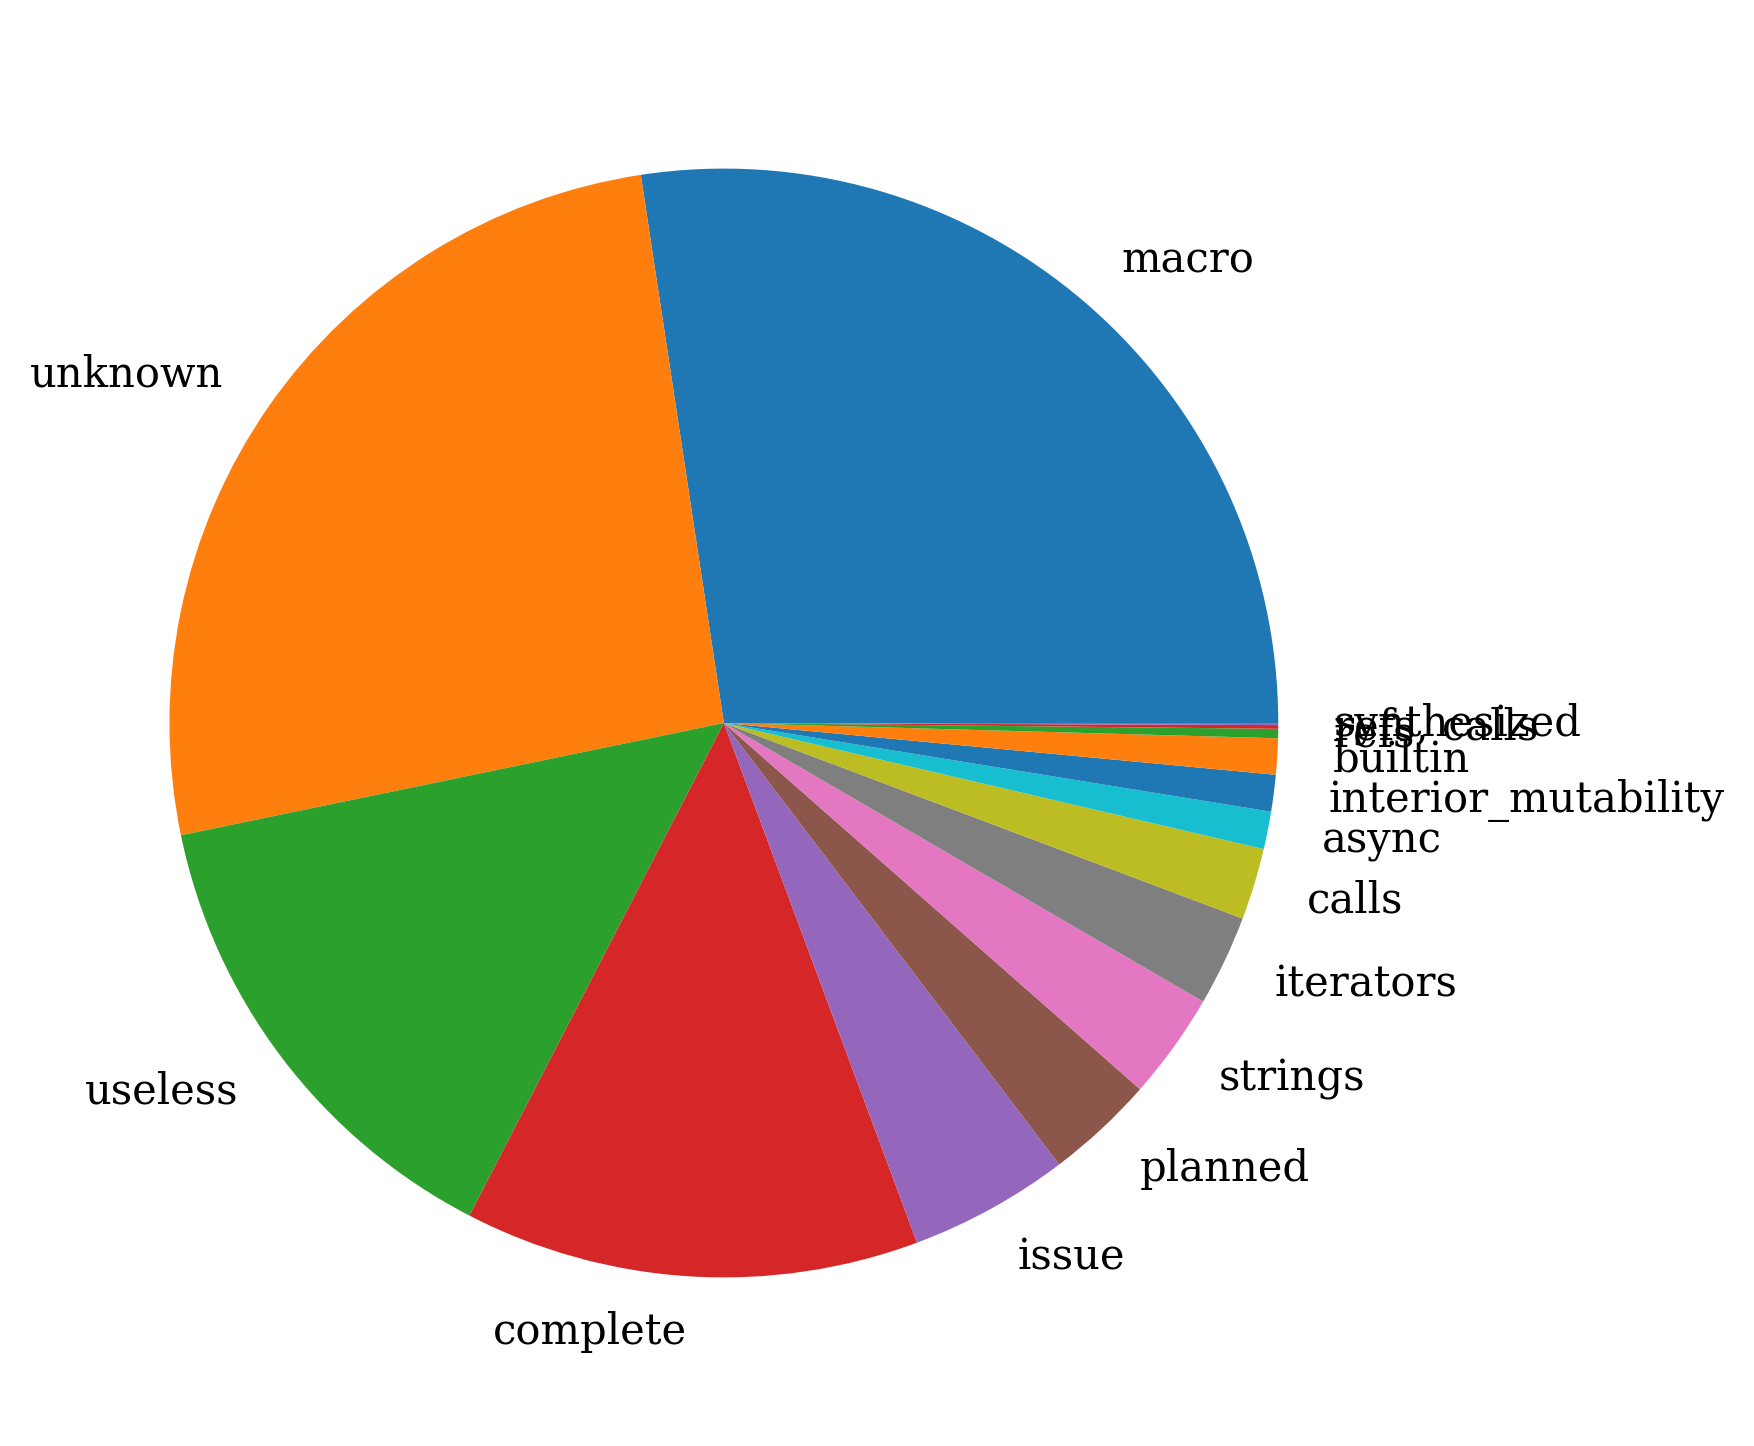

In [20]:
# don't label axes
progress_tally.plot(kind='pie', y='count', figsize=(8, 6), legend=False, ylabel='')

In [21]:
macro_counts = sum_counts(all_calls, ['macro']).copy()
for (macro, count) in macro_counts.values[:20]:
	print(f"{count}x {macro}")

45505472x 
8403994x serde_derive::Deserialize
4020577x quote::quote
4019790x core::fmt::macros::Debug
2145961x core::clone::Clone
2130288x serde_derive::Serialize
1970558x alloc::macros::format
1270583x core::cmp::PartialEq
1129711x prost_derive::Message
1125126x core::macros::write
834400x core::default::Default
563725x alloc::macros::vec
471732x tracing::macros::trace
468446x clap_derive::Parser
452081x schemars_derive::JsonSchema
449097x tracing::macros::debug
357133x bitflags::bitflags
350308x log::macros::debug
325344x std::macros::println
320121x std::macros::panic


<AxesSubplot: title={'center': 'Top Macros by Usage'}>

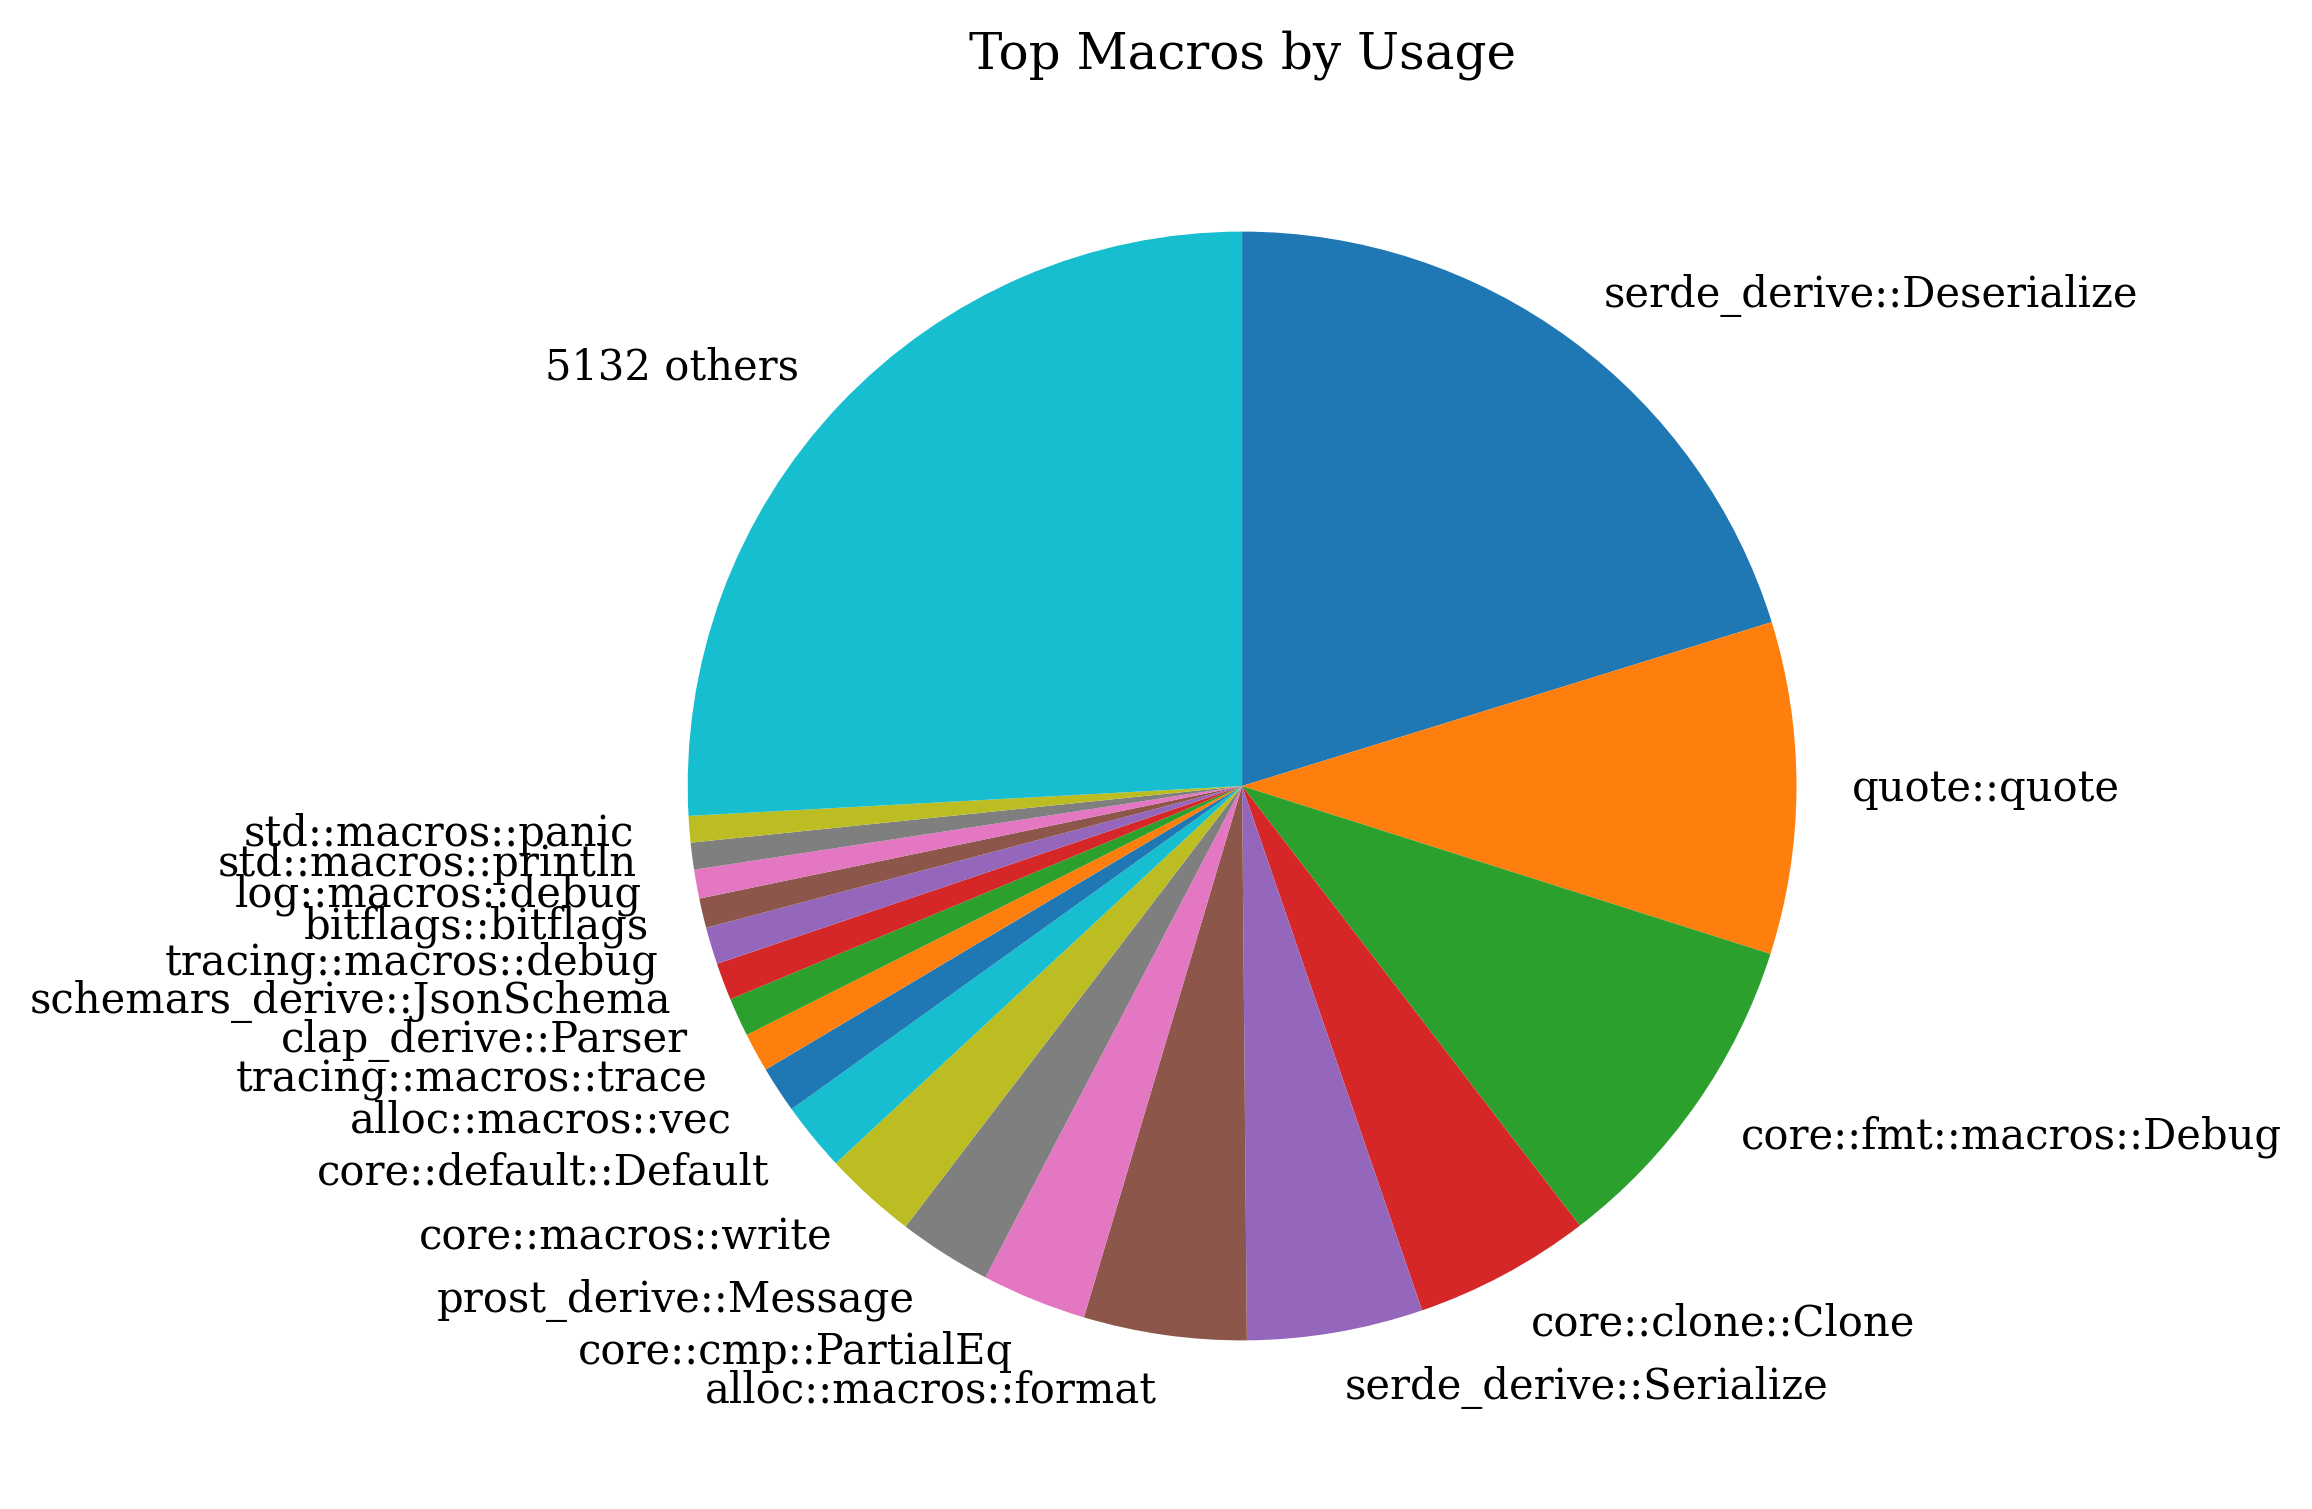

In [22]:
top_macro_counts = macro_counts.copy()
top_macro_counts.set_index('macro', inplace=True)
top_macro_counts.drop([""], inplace=True)
cut_off_after_top(19, top_macro_counts)

top_macro_counts.plot(kind='pie', y='count', figsize=(8, 6), legend=False, ylabel='', startangle=90, counterclock=False, title="Top Macros by Usage")

In [23]:
all_calls[all_calls["macro"] == "ruc::eg"]

,receiver,receiver_generics,target,target_type_generics,target_function_generics,caller_crate,target_crate,macro,count
597066,,,alloc::boxed::Box<T>::new,ruc::err::SimpleError<alloc::string::String>,,fbnc,alloc,ruc::eg,2
600161,,,alloc::fmt::format,,,fbnc,alloc,ruc::eg,2
661799,,,core::fmt::ArgumentV1::new_display,,core::fmt::Arguments,fbnc,core,ruc::eg,2
663447,,,core::fmt::ArgumentV1::new_display,,&str,fbnc,core,ruc::eg,2
665086,,,core::fmt::Arguments::new_v1,,,fbnc,core,ruc::eg,4
801887,,,ruc::err::SimpleError<E>::new,alloc::string::String,,fbnc,ruc,ruc::eg,2
801889,,,ruc::err::SimpleMsg<E>::new,alloc::string::String,,fbnc,ruc,ruc::eg,2
9412898,,,alloc::boxed::Box<T>::new,ruc::err::SimpleError<alloc::string::String>,,eth_utils,alloc,ruc::eg,5
9415234,,,alloc::fmt::format,,,eth_utils,alloc,ruc::eg,5
9455898,,,core::fmt::ArgumentV1::new_display,,core::fmt::Arguments,eth_utils,core,ruc::eg,5


In [24]:
def compute_totals(cumulative: pd.DataFrame):
	sum = 0
	total = cumulative['count'].sum()
	for i in cumulative.index:
		sum += cumulative.loc[i, "count"]
		cumulative.loc[i, "total"] = sum / total

cumulative_counts = sum_counts(all_calls, ['target', 'receiver']).copy()
compute_totals(cumulative_counts)

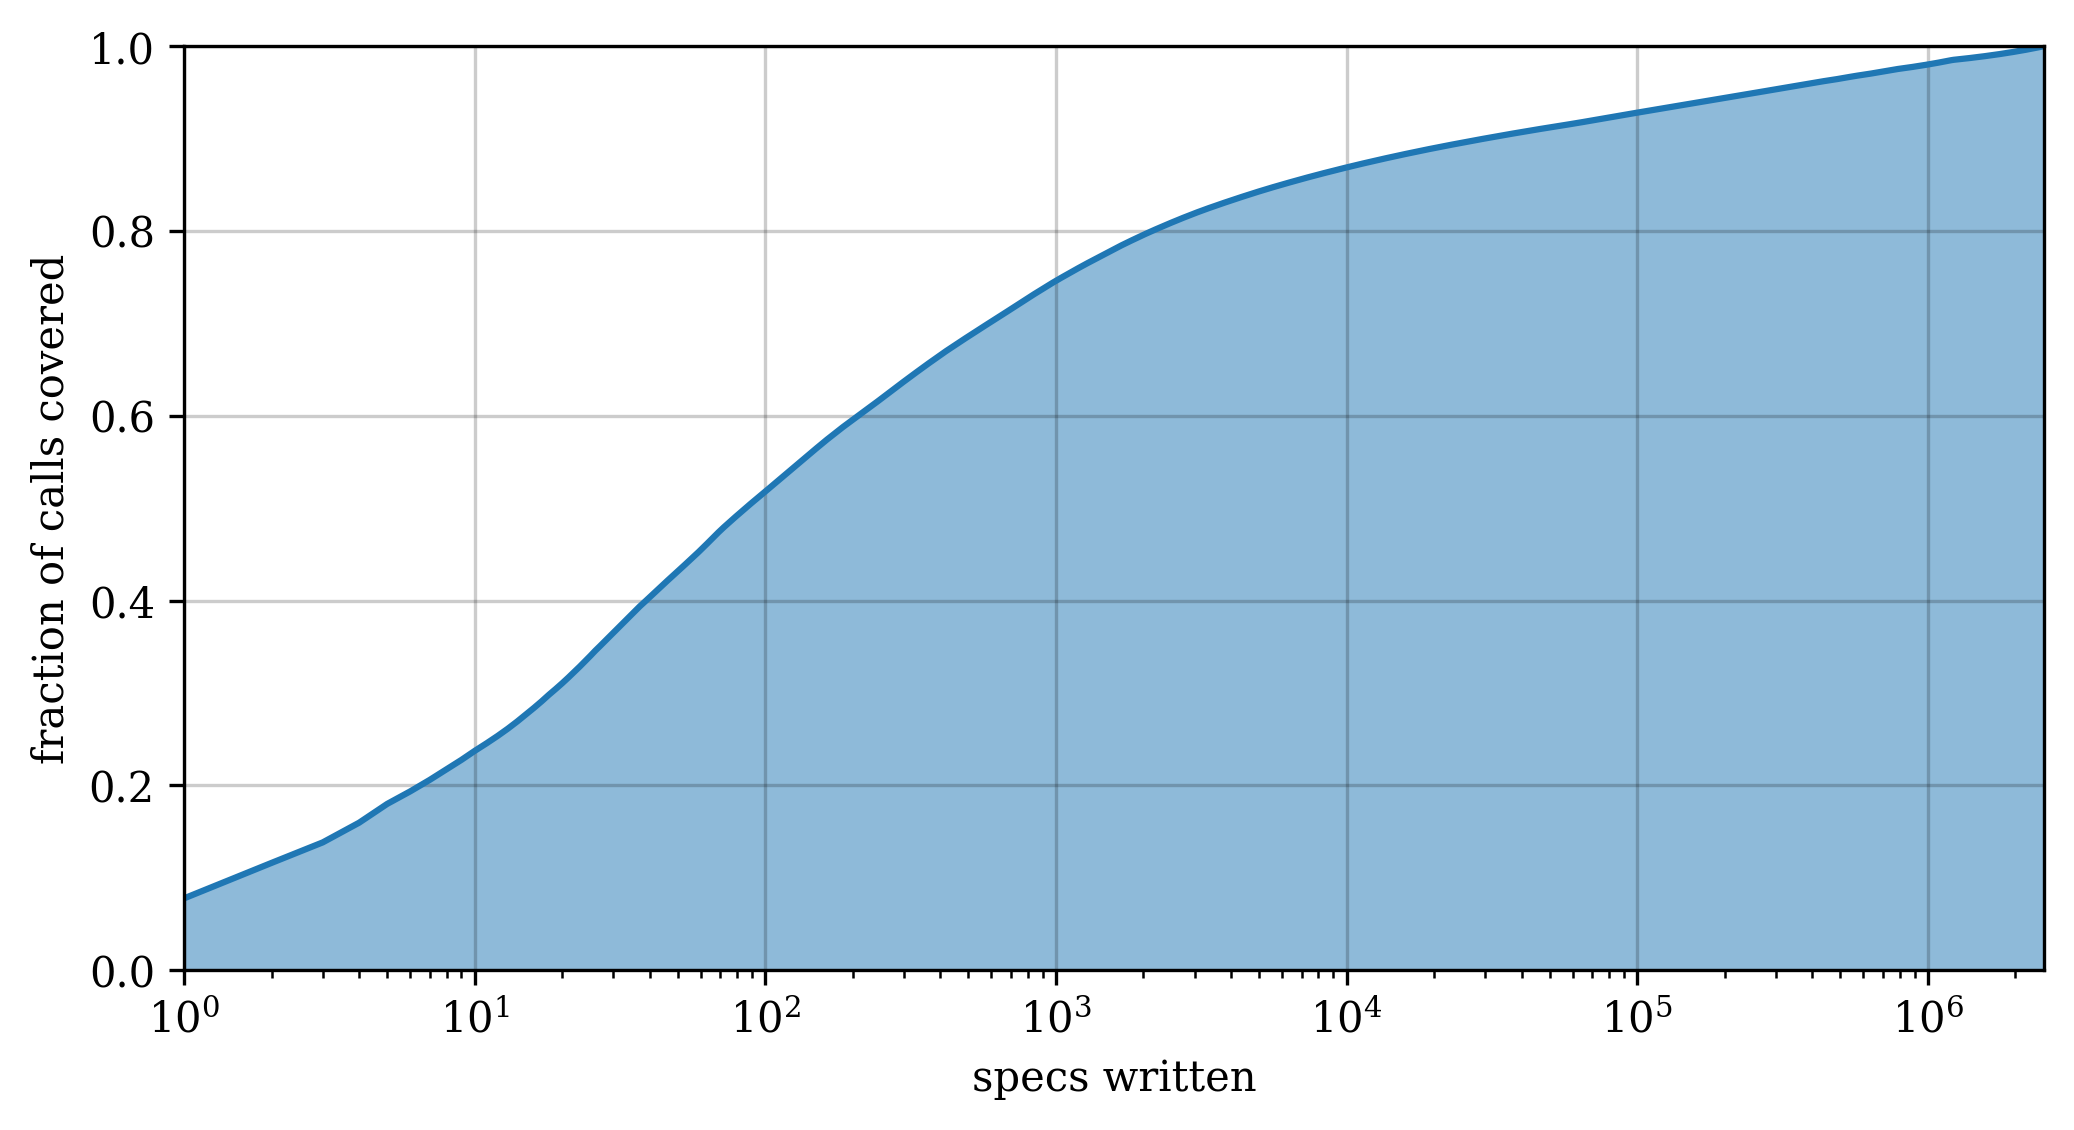

In [25]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()
ax.grid(color=(0, 0, 0), alpha=0.2)
ax.plot(cumulative_counts.index, cumulative_counts["total"])
ax.fill_between(cumulative_counts.index, cumulative_counts["total"], alpha=0.5)
plt.xlim(1, cumulative_counts.index.max())
plt.ylim(0, 1)
plt.xscale('log')
plt.ylabel("fraction of calls covered")
plt.xlabel("specs written")
plt.show()

In [26]:
counts = all_calls["count"]

def print_details(mask):
	masked = counts[mask]
	print(f"Calls: {masked.count()} / {counts.count()}")
	print(f"Occurrences: {masked.sum()} / {counts.sum()}")

print(f"< 10:")
print_details(counts < 10)
print()
print(f"> 1000:")
print_details(counts > 1000)

< 10:
Calls: 14932502 / 16101123
Occurrences: 29065492 / 87060395

> 1000:
Calls: 4445 / 16101123
Occurrences: 10992872 / 87060395


In [27]:
by_target = sum_counts(all_calls, ['target', 'target_crate'])
by_target

,target,target_crate,count
0,core::cmp::PartialEq::eq,core,5122320
1,core::ops::deref::Deref::deref,core,4161020
2,core::clone::Clone::clone,core,3502722
3,core::ops::try_trait::Try::branch,core,3457142
4,core::ops::try_trait::FromResidual::from_residual,core,3457138
5,core::fmt::Formatter::write_str,core,3416666
6,core::default::Default::default,core,1900443
7,core::fmt::Arguments::new_v1,core,1851757
8,core::fmt::ArgumentV1::new_display,core,1774675
9,quote::__private::push_ident,quote,1180899


In [28]:
cumulative_by_target = by_target.copy()
compute_totals(cumulative_by_target)

In [29]:
majority_by_target = len(cumulative_by_target[cumulative_by_target["total"] < 0.5]) + 1
print(majority_by_target, len(cumulative_by_target), 100 * majority_by_target / len(cumulative_by_target))
majority_by_call = len(cumulative_counts[cumulative_counts["total"] < 0.5]) + 1
print(majority_by_call, len(cumulative_counts), 100 * majority_by_call / len(cumulative_counts))

27 446378 0.006048685195058896
87 2512426 0.0034627885557624383


In [30]:
top_usage_counts = by_target.copy()
top_usage_counts.set_index('target', inplace=True)
cut_off_after_top(27, top_usage_counts)

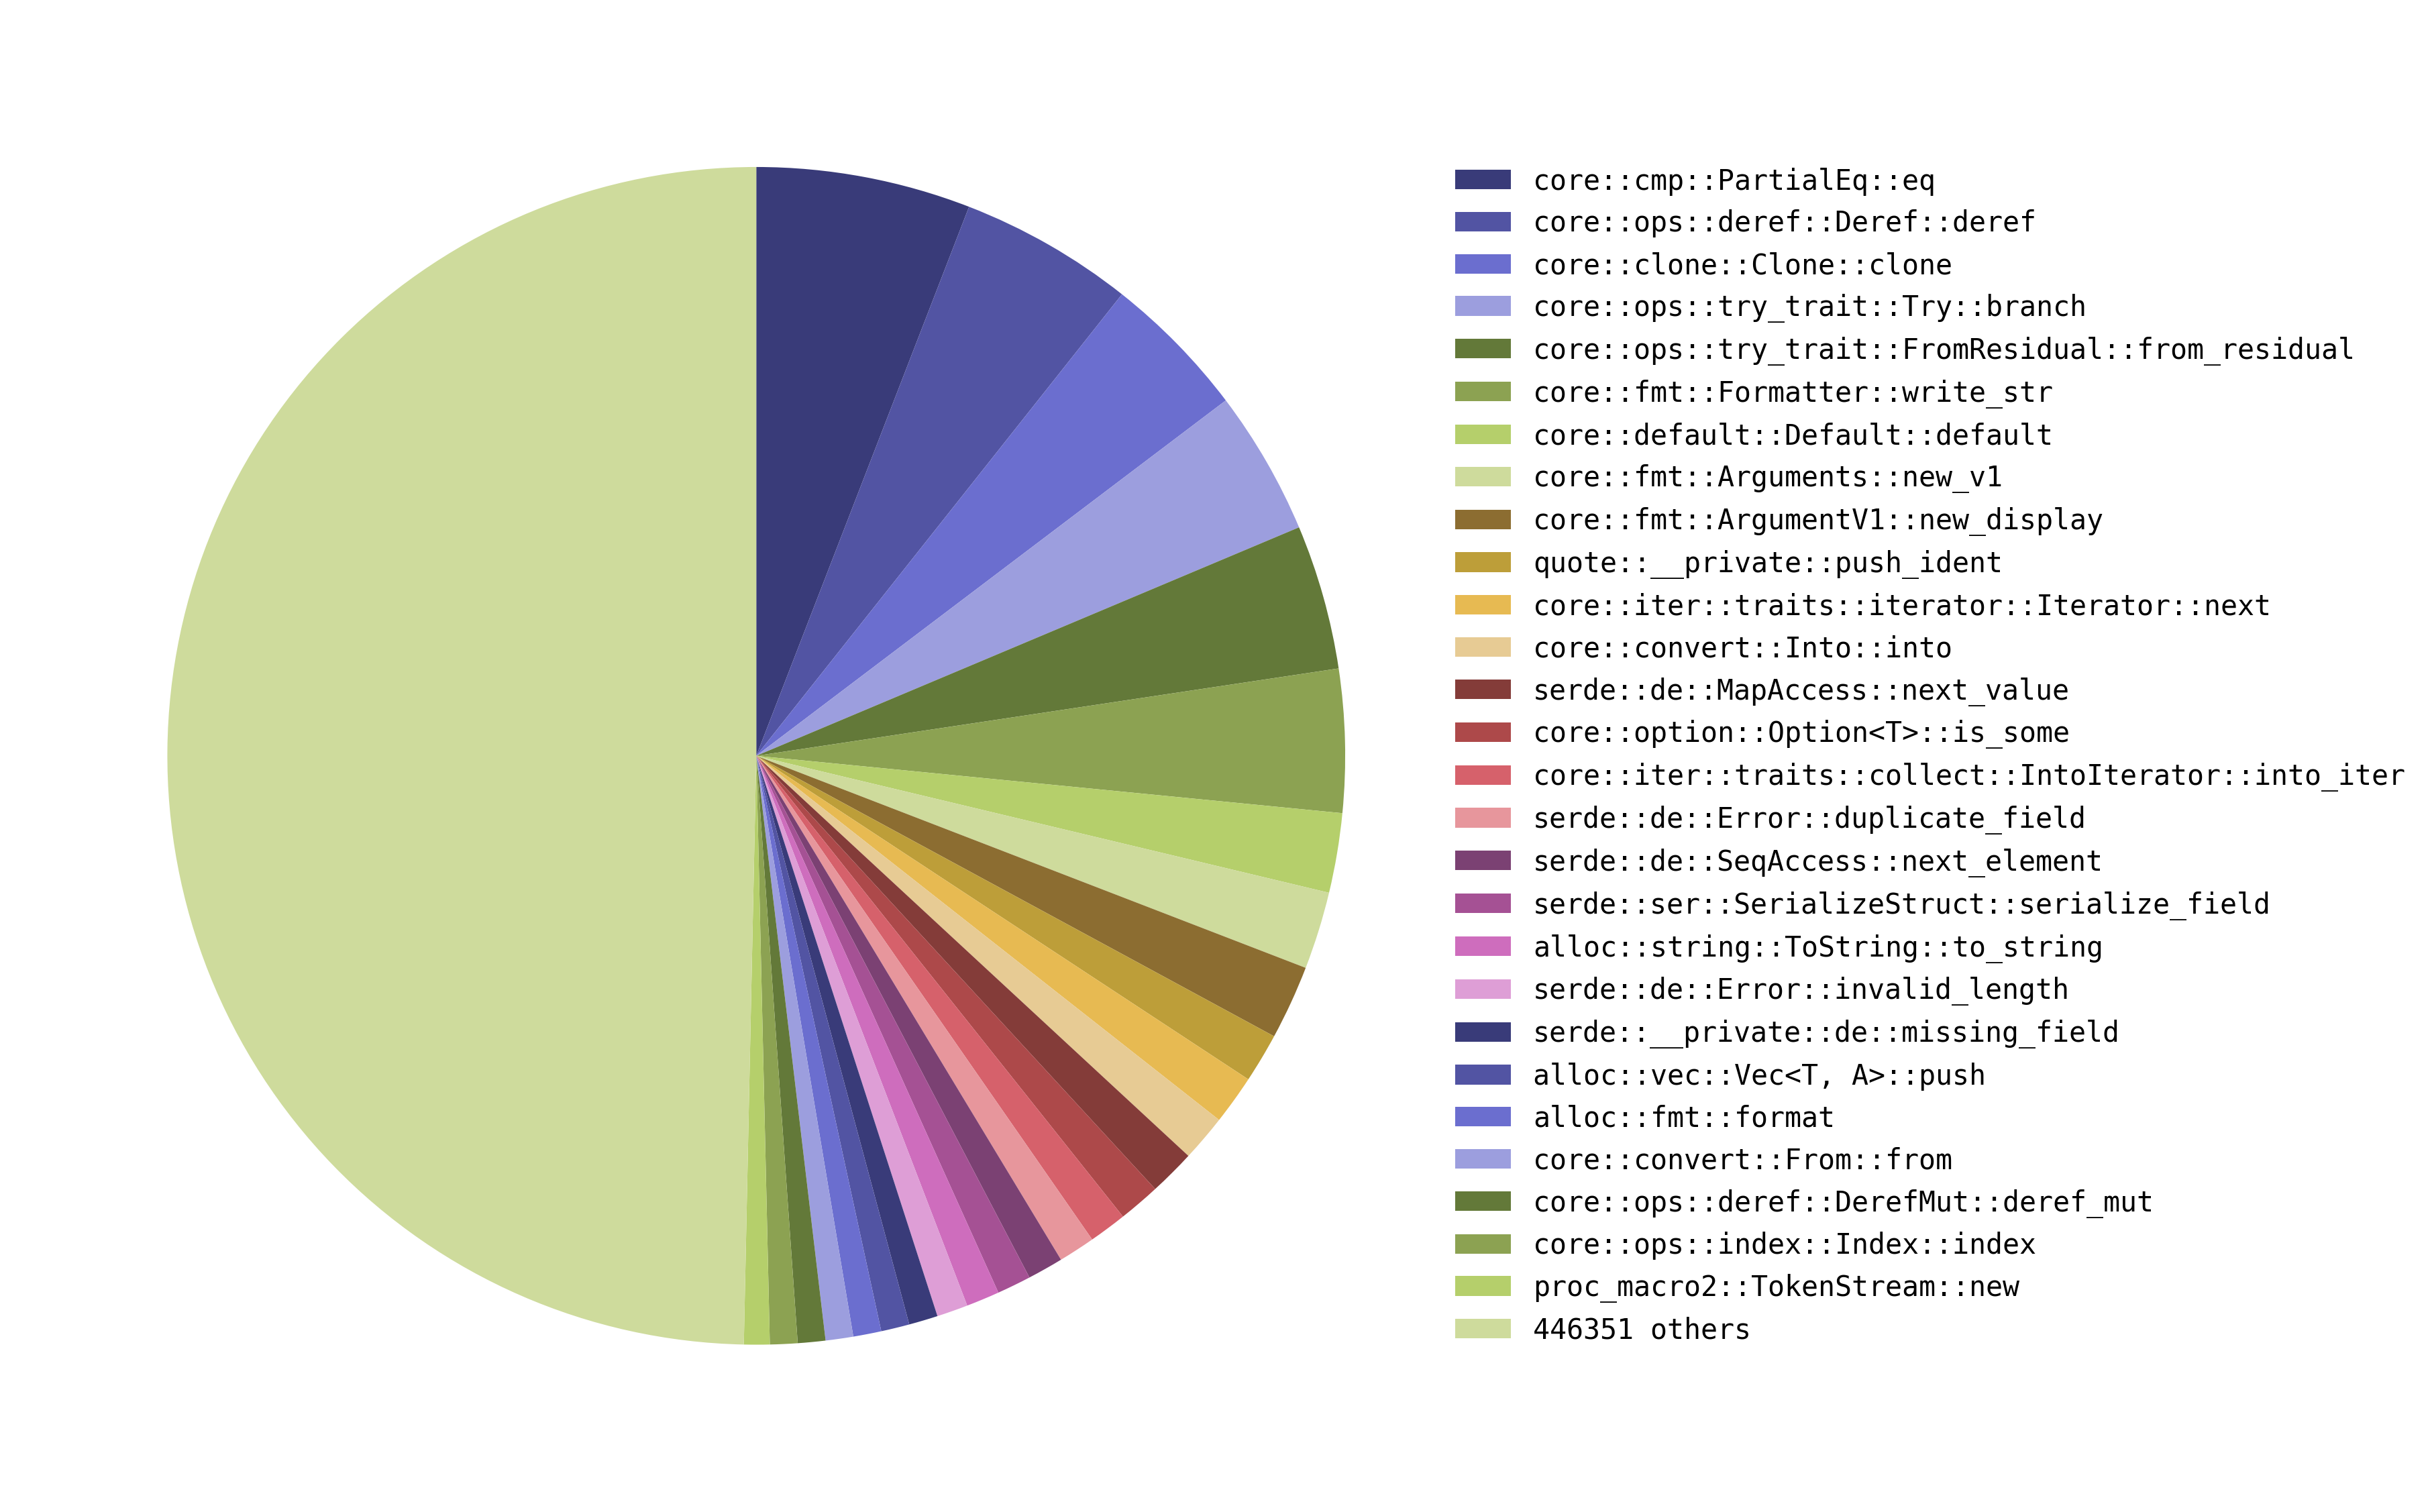

In [31]:

fig, ax = plt.subplots(figsize=(17, 9.5))
#colors = plt.cm.get_cmap('twilight')(np.linspace(0, 1, 29))
colors = plt.cm.get_cmap('tab20b').colors
ax.pie(top_usage_counts['count'], startangle=90, counterclock=False, rotatelabels=False, colors=colors)
fig.legend(top_usage_counts.index, loc="center right", prop=monospace, frameon=False)
fig.show()

In [32]:
# print full list of most popular targets in a single crate

crate_filter = "core"
filtered = by_target[by_target['target_crate'] == crate_filter].reset_index(names='global_rank')
for i in range(min(100_000, len(filtered))):
	row = filtered.loc[i]
	print(f"{row['target']} - #{i + 1} (#{row['global_rank'] + 1} globally, {row['count']}x)")

core::cmp::PartialEq::eq - #1 (#1 globally, 5122320x)
core::ops::deref::Deref::deref - #2 (#2 globally, 4161020x)
core::clone::Clone::clone - #3 (#3 globally, 3502722x)
core::ops::try_trait::Try::branch - #4 (#4 globally, 3457142x)
core::ops::try_trait::FromResidual::from_residual - #5 (#5 globally, 3457138x)
core::fmt::Formatter::write_str - #6 (#6 globally, 3416666x)
core::default::Default::default - #7 (#7 globally, 1900443x)
core::fmt::Arguments::new_v1 - #8 (#8 globally, 1851757x)
core::fmt::ArgumentV1::new_display - #9 (#9 globally, 1774675x)
core::iter::traits::iterator::Iterator::next - #10 (#11 globally, 1177558x)
core::convert::Into::into - #11 (#12 globally, 1112335x)
core::option::Option<T>::is_some - #12 (#14 globally, 998312x)
core::iter::traits::collect::IntoIterator::into_iter - #13 (#15 globally, 903477x)
core::convert::From::from - #14 (#24 globally, 659319x)
core::ops::deref::DerefMut::deref_mut - #15 (#25 globally, 659261x)
core::ops::index::Index::index - #16 (#26 

In [33]:
by_crate = sum_counts(all_calls, ['target_crate']).set_index('target_crate')
by_crate

,count
target_crate,
core,53860887
serde,7596756
alloc,5584314
quote,3728109
std,1791127
clap,1425205
tracing_core,1180971
proc_macro2,764877
log,641517


<AxesSubplot: ylabel='count'>

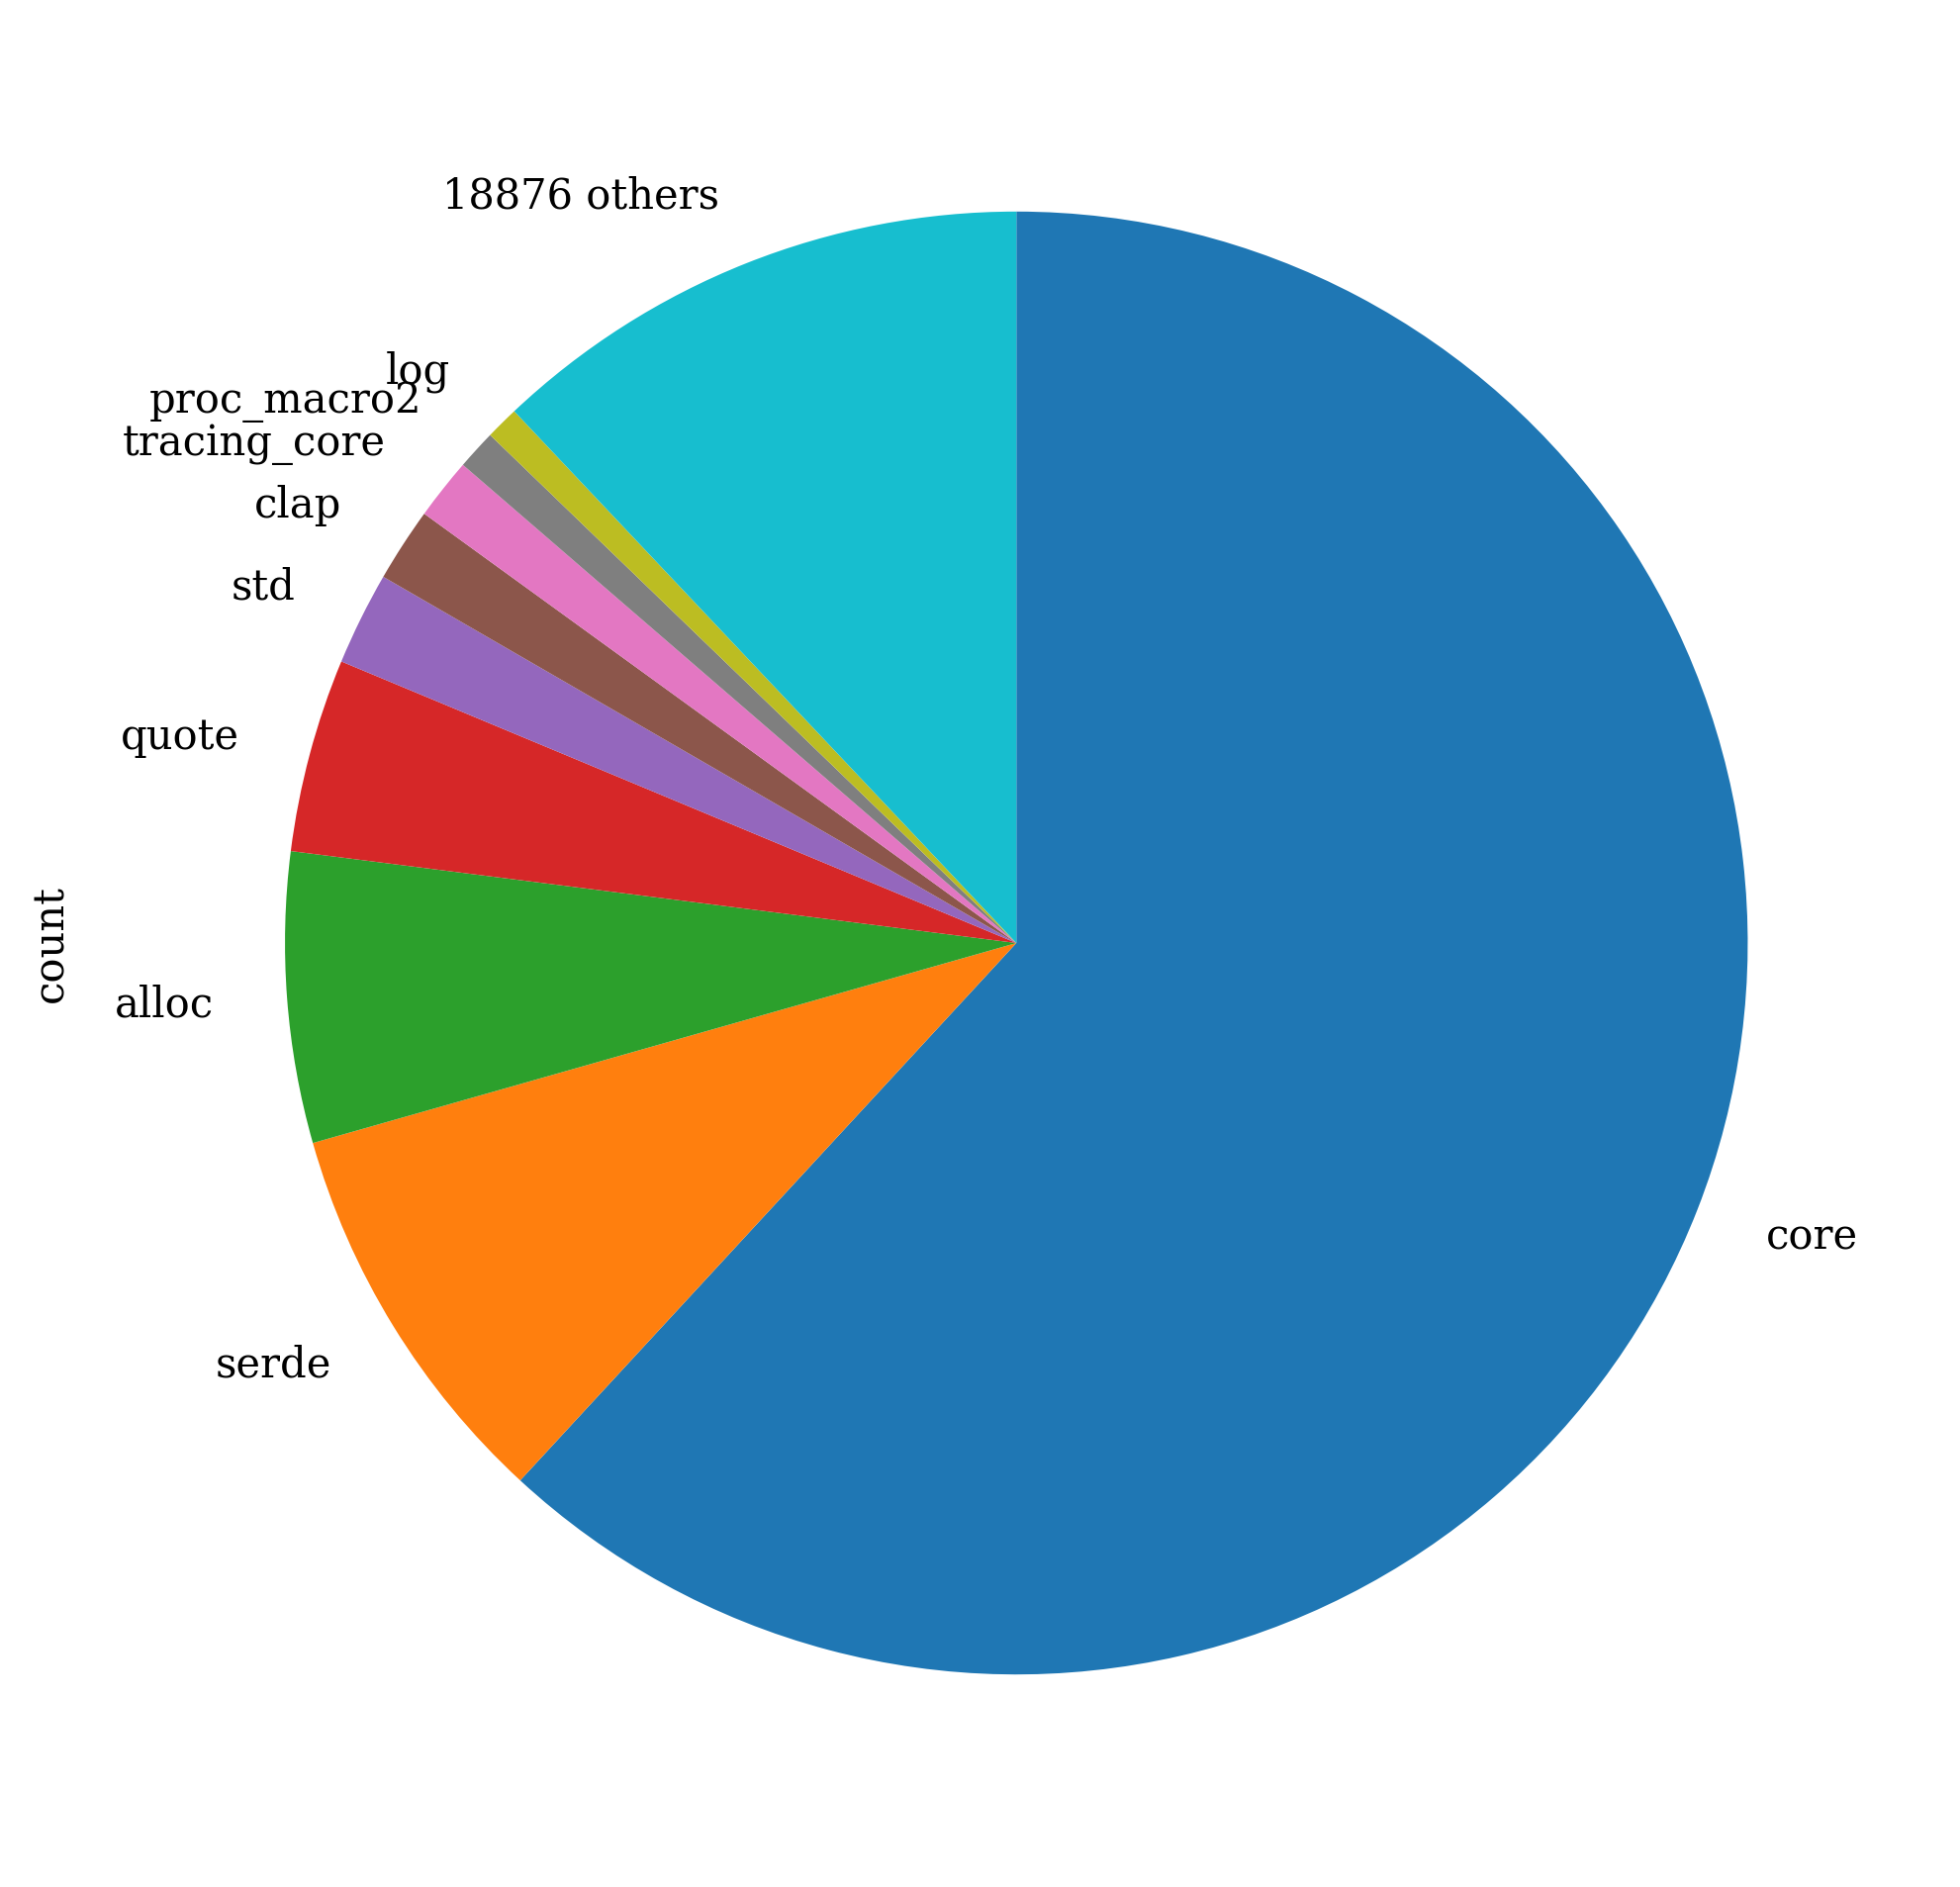

In [34]:
cut_off_after_top(9, by_crate)
by_crate.plot(kind='pie', y='count', legend=False, startangle=90, counterclock=False)